<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://cdn.miami.edu/_assets-common/images/system/um-logo-gray-bg.png" alt="Miami Logo" style="height: 98px;">
</div>

<h1>MPO 624: A multivariate dataset on ENSO</h1>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

### ENSO science from data 
1. <a href="#import">Importing data</a>
1. <a href="#select">Select NINO 3 and 4 series data</a>
1. <a href="#anomaly">Subtract mean annual cycle</a>
1. <a href="#regress">Regressions</a>
1. <a href="#lagregress">Lag Regressions</a>

<a name="import"></a>
### Import our dataset (in current directory)

In [19]:
import numpy as np
from netCDF4 import Dataset

datafile = Dataset('Eq_timelon_sections.nc',mode='r')

# Trick: a loop over keys, building a command. Then, execute that command!

for key in datafile.variables.keys(): 
    print( key +"=datafile['"+key+"'][:].squeeze()") # to show the command
    exec( key +"=datafile['"+key+"'][:].squeeze()")
datafile.close()

lon=datafile['lon'][:].squeeze()
time=datafile['time'][:].squeeze()
olr=datafile['olr'][:].squeeze()
precip=datafile['precip'][:].squeeze()
slp=datafile['slp'][:].squeeze()
sst=datafile['sst'][:].squeeze()
uwnd=datafile['uwnd'][:].squeeze()


Populating the interactive namespace from numpy and matplotlib


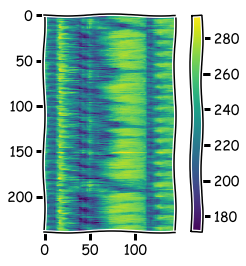

In [47]:
%pylab inline
plt.xkcd() # whiteboard style

imshow(olr); colorbar()

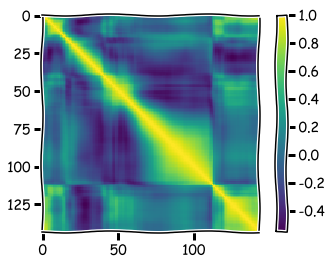

In [38]:
cormat = np.corrcoef( np.transpose(olr) )
covmat = np.cov( np.transpose(olr) )
                     
imshow(cormat)
colorbar()

In [40]:
np.linalg.matrix_rank(covmat)

144

143

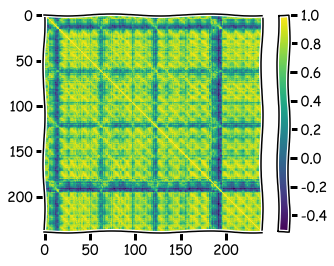

In [45]:
cormat = np.corrcoef(olr)
covmat = np.cov(olr)

imshow(cormat)
colorbar()
np.linalg.matrix_rank(covmat)

TypeError: Image data cannot be converted to float

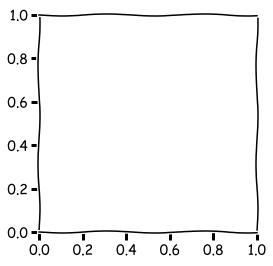

In [49]:
imshow(olr.transpose); colorbar()

In [11]:
# Rename time to something that will not collide with "time" 
yyyy = 1980.0 + (time + 0.5)/12. # 0.5 is the center of each month

### This command is just like Matlab: WHO'S IN THERE?  
##### But it must be at the TOP of its cell.

In [12]:
whos

Variable   Type       Data/Info
-------------------------------
CPAC       ndarray    240x1: 240 elems, type `float32`, 960 bytes
Dataset    type       <class 'netCDF4._netCDF4.Dataset'>
EPAC       ndarray    240x1: 240 elems, type `float32`, 960 bytes
calmos     ndarray    12: 12 elems, type `int64`, 96 bytes
datafile   Dataset    <object with id 4662369880 (str() failed)>
imo        int64      11
key        str        uwnd
lon        ndarray    144: 144 elems, type `float32`, 576 bytes
months     ndarray    240: 240 elems, type `int64`, 1920 bytes
olr        ndarray    240x144: 34560 elems, type `float32`, 138240 bytes (135.0 kb)
precip     ndarray    240x144: 34560 elems, type `float32`, 138240 bytes (135.0 kb)
slp        ndarray    240x144: 34560 elems, type `float32`, 138240 bytes (135.0 kb)
sst        ndarray    240x144: 34560 elems, type `float32`, 138240 bytes (135.0 kb)
time       ndarray    240: 240 elems, type `float32`, 960 bytes
uwnd       ndarray    240x144: 34560 elems, 

### Now I grab CPAC and EPAC time series: a _pylab_ way
##### Pylab magic (the % is for "magics" and must be at the TOP of its cell)
Pylab is "not recommeded", it has dangers - but acts like Matlab, simple for quick looks

In [13]:
%pylab inline
plt.xkcd() # whiteboard style

Populating the interactive namespace from numpy and matplotlib


//anaconda/envs/MPO624/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [14]:
time # CAREFUL! Pylab overwrote one of our variables! 

<module 'time' (built-in)>

<a name="select"></a>
### Select location with FIND
CAREFUL: Only works for values that are exact! 

Text(0.5,1,'CPAC and EPAC SST (240 mos, from Jan 1980)')

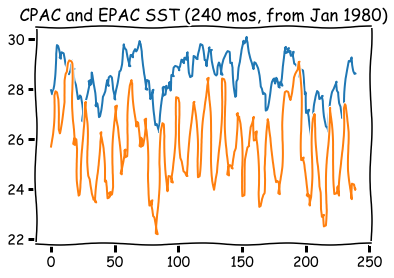

In [15]:
CPAC = sst[:,find(lon == 185)]
EPAC = sst[:,find(lon == 240)]
plot(CPAC); plot(EPAC); 
title('CPAC and EPAC SST (240 mos, from Jan 1980)')

<a name="anomaly"></a>
## Remove seasonality

Seasonality's web of causality has all variables (all over the globe) forced by the sun. 

ENSO's web is different (along the equator, wind pushes the ocean, ocean SST drives convection, convection drives the wind -- a coupled system). 

**It is physically meaningless to study "variability" that is an unmanaged blend of a forced cycle and a free oscillation!**

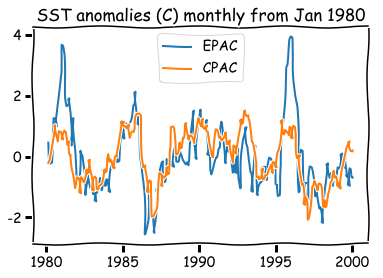

In [16]:
calmos = arange(12) ## Runs from 0-11, not 1-12, CAREFUL! 

# I happen to know the data begin with a January. CAREFUL! Not a general approach
months = arange(size(EPAC)) 
for imo in calmos:
    yess = find(imo == months%12)
    EPAC[yess] -= mean(EPAC[ yess ] )
    CPAC[yess] -= mean(CPAC[ yess ] )

# Let's make a plot. Again Pylab has its cheats... I just happen to know times

plot(yyyy, EPAC, label='EPAC'); 
plot(yyyy, CPAC, label='CPAC'); 
title('SST anomalies (C) monthly from Jan 1980')
legend(loc='best')

#### Hmm, they look rather similar. But there is a little bit of indepependent information. Wonder what the correlation is? 

0.64983976 0.69002205 1.3842258
Wow, shared variance is only  42.22917122121004 %


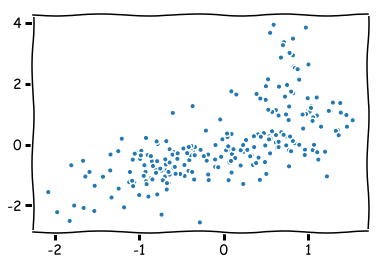

In [17]:
# corrcoef( transpose(CPAC), transpose(EPAC) )
cor = mean(CPAC*EPAC) / std(CPAC) / std(EPAC)
print( cor, var(CPAC), var(EPAC) )
print( 'Wow, shared variance is only ', 100*cor**2,'%' )
plot(CPAC,EPAC,'.')

In [ ]:
import scipy, scipy.stats
# ?scipy.stats.linregress

# let's fit a line. EPAC regressed on CPAC in (CPAC,EPAC) calling order:   
slope, intercept, r_value, p_value, std_err = \
    scipy.stats.linregress(transpose(CPAC),transpose(EPAC))
    
EfromC = intercept + slope*CPAC
print( slope, intercept )
print("r-squared:", r_value**2)

In [ ]:
slope, intercept, r_value, p_value, std_err = \
    scipy.stats.linregress(transpose(EPAC),transpose(CPAC))
 
CfromE = intercept + slope*EPAC
print( slope, intercept )
print("r-squared:", r_value**2)

<a name="regress"></a>
## A good example of asymmetric regressions

In [ ]:
plot(CPAC,EPAC,'.')
plot(CPAC,EfromC)
plot(CfromE, EPAC)

In [ ]:
## Plot the indidvidual regressions
### Can only be the same series, scaled to have 44% as much variance! 

In [ ]:
# Plot the indidvidual regressions

figure(figsize=[10,10])

subplot(211)
plot(yyyy, EPAC,  'b' , label='EPAC,  var '+str(var(EPAC)) )
plot(yyyy, CPAC,  'r' , label='CPAC,  var '+str(var(CPAC)) )
plot(yyyy, EfromC,'b:', label='EfromC,var '+str(var(EfromC)) )
title('SST anomalies (C) monthly from Jan 1980')
legend(loc='best')

subplot(212)
plot(yyyy, CPAC,  'r' , label='CPAC,   var '+str(var(CPAC)) )
plot(yyyy, EPAC,  'b' , label='EPAC,   var '+str(var(EPAC)) )
plot(yyyy, CfromE,'r:', label='CfromE, var '+str(var(CfromE)) )
title('SST anomalies (C) monthly from Jan 1980')
legend(loc='best')

In [ ]:
ssta = sst.copy() # anomaly array copy
for ilon in arange(len(lon)): 
    for imo in calmos:
        calmo = find(imo == months%12)
        ssta[calmo,ilon] -= mean( sst[calmo,ilon] )

contourf(lon, yyyy, ssta)
title('SSTA in K')
colorbar()

<a name="lagregress"></a>
### Lag regressions of SST everywhere, relative to EPAC, CPAC. 
#### Define the 'result' array. Then fill it with a loop. Then display it. 

In [ ]:
# Longitude-lag arrays are the results space
lags = arange(-12,13,1)
print(lags)

In [ ]:
# Use the CPAC time series as the reference or "base" time series 

# Answer shaped containers
Covs_fromC = zeros( (len(lags), len(lon))  )
Corrs_fromC = zeros( (len(lags), len(lon))  )

# Loop and fill
for ilag in arange(len(lags)): 
    for ilon in arange(len(lon)):
        
# Roll is a periodic shift of an array. 
# Rolling across the beginning and end will be an error! 
# If there's lots of data, this is a small error... 

        ts1 = roll(CPAC,lags[ilag]).squeeze()
        ts2 = ssta[:,ilon].squeeze()

        Covs_fromC[ilag,ilon]  = mean(ts1*ts2)
        Corrs_fromC[ilag,ilon] = mean(ts1*ts2) /std(ts1)/std(ts2)


In [ ]:
contourf(lon, lags, Covs_fromC)
title('Covariance: units are K^2')
colorbar()

In [ ]:
contourf(lon, lags, Corrs_fromC)
colorbar()
title("Correlation: unitless, 1 at base longitude and zero lag")

In [ ]:
## That is kind of a "typical event" composite: can we see 130E feature in data?

In [ ]:
contourf(lon, yyyy, ssta)
title('SSTA in K')
colorbar()

In [ ]:
# Use the CPAC time series as the reference or "base" time series 

# Answer shaped containers
Covs_fromE = zeros( (len(lags), len(lon))  )
Corrs_fromE = zeros( (len(lags), len(lon))  )

# Loop and fill
for ilag in arange(len(lags)): 
    for ilon in arange(len(lon)):
        
# Roll is a periodic shift of an array. 
# Rolling across the beginning and end will be an error! 
# If there's lots of data, this is a small error... 

        ts1 = roll(EPAC,lags[ilag]).squeeze()
        ts2 = ssta[:,ilon].squeeze()

        Covs_fromE[ilag,ilon]  = mean(ts1*ts2)
        Corrs_fromE[ilag,ilon] = mean(ts1*ts2) /std(ts1)/std(ts2)


In [ ]:
contourf(lon, lags, Covs_fromE)
title('Covariance: units are K^2')
colorbar()

In [ ]:
contourf(lon, lags, Corrs_fromE)
colorbar()
title("Correlation: unitless, 1 at base longitude and zero lag")

In [ ]:
## That is kind of a "typical event" composite: can we see it all in data?

In [ ]:
contourf(lon, yyyy, ssta, cmap='seismic', vmin=-4, vmax=4)
title('SSTA in K')
colorbar()